In [1]:
print("HELLO")

HELLO


In [2]:
import time
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [3]:

#text libraries
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import word2vec

In [4]:

# classifier imports
from sklearn.neural_network import MLPClassifier

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# copy test id column for later submission
result = test[['id']].copy() 
# show first 3 rows of the training set to get a first impression about the data
print(train.head(3))

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  


In [6]:
# count each severity 
print('toxic: %d' % train[train['toxic'] > 0]['toxic'].count())
print('severe_toxic: %d' % train[train['severe_toxic'] > 0]['severe_toxic'].count())
print('obscene: %d' % train[train['obscene'] > 0]['obscene'].count())
print('threat: %d' % train[train['threat'] > 0]['threat'].count())
print('insult: %d' % train[train['insult'] > 0]['insult'].count())
print('identity_hate: %d' % train[train['identity_hate'] > 0]['identity_hate'].count())

toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405


In [7]:
print('Severe toxic but NOT toxic?: %d' % train[(train['severe_toxic'] > 0) & (train['toxic'] == 0)]['id'].count())
print('Insult but NOT toxic?: %d' % train[(train['insult'] > 0) & (train['toxic'] == 0)]['id'].count())
print('Obscene but NOT toxic?: %d' % train[(train['obscene'] > 0) & (train['toxic'] == 0)]['id'].count())
print('Threat but NOT insult?: %d' % train[(train['threat'] > 0) & (train['insult'] == 0)]['id'].count())

Severe toxic but NOT toxic?: 0
Insult but NOT toxic?: 533
Obscene but NOT toxic?: 523
Threat but NOT insult?: 171


In [8]:
train['len'] = train['comment_text'].str.len()
print('Average comment length: %d' % train['len'].mean())
print('Median comment length: %d' % train['len'].quantile(.5))
print('90th percentile comment length: %d' % train['len'].quantile(.9))

Average comment length: 394
Median comment length: 205
90th percentile comment length: 889


In [9]:
print(train[train['comment_text'].isnull()])
print(test[test['comment_text'].isnull()])

Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate, len]
Index: []
Empty DataFrame
Columns: [id, comment_text]
Index: []


In [10]:
test['comment_text'].fillna(value='none', inplace=True) # there is one 
train['comment_text'].fillna(value='none', inplace=True)

In [11]:
def text_to_words(raw_text, remove_stopwords=False):
    # 1. Remove non-letters, but including numbers
    letters_only = re.sub("[^0-9a-zA-Z]", " ", raw_text)
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english")) # In Python, searching a set is much faster than searching
        meaningful_words = [w for w in words if not w in stops] # Remove stop words
        words = meaningful_words
    return words 

sentences_train = train['comment_text'].apply(text_to_words, remove_stopwords=False)
sentences_test = test['comment_text'].apply(text_to_words, remove_stopwords=False)
# show first three arrays as sample
print(sentences_train[:3])

0    [explanation, why, the, edits, made, under, my...
1    [d, aww, he, matches, this, background, colour...
2    [hey, man, i, m, really, not, trying, to, edit...
Name: comment_text, dtype: object


In [12]:
from gensim.models import Word2Vec

In [14]:

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [15]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = Word2Vec(sentences=sentences_train, vector_size=num_features, window=context, min_count=min_word_count, sample=downsampling, workers=num_workers)
# Assuming 'model' is your trained Word2Vec model
# Save the model's word vectors and discard the full model to save memory
word_vectors = model.wv
word_vectors.save("word_vectors.kv")

# Optionally, you can later load these vectors without the full model:
word_vectors = KeyedVectors.load("word_vectors.kv", mmap='r')

# Now you can use `word_vectors` for querying, which is memory efficient

In [16]:
def makeFeatureVec(words, model, num_features):
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.index_to_key)  # Updated to use index_to_key
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords += 1
            featureVec = np.add(featureVec, model[word])  # Updated to use model.wv[word]
    # Divide the result by the number of words to get the average
    if nwords == 0:
        nwords = 1  # Avoid division by zero
    featureVec = np.divide(featureVec, nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    counter = 0
    # Loop through the reviews
    for review in reviews:
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter += 1
    return reviewFeatureVecs


In [17]:
from gensim.models import KeyedVectors
# Assuming word_vectors.kv is already loaded
word_vectors = KeyedVectors.load("word_vectors.kv", mmap='r')

f_matrix_train = getAvgFeatureVecs(sentences_train, word_vectors, num_features)
f_matrix_test = getAvgFeatureVecs(sentences_test, word_vectors, num_features)
# we have to train 6 different models with 6 different Y labels
y = [train['toxic'], train['severe_toxic'], train['obscene'], train['threat'], train['insult'], train['identity_hate']]

In [18]:
# create 6 MLP models
model = []
for i in range(0, 6):
    m = MLPClassifier(solver='adam', hidden_layer_sizes=(30,30,30), random_state=1)
    model.append(m)
print(model)


[MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1)]


In [19]:
batch_size = 10000
total_rows = f_matrix_train.shape[0]
duration = 0
start_train = time.time()
pos = 0
classes = [0,1]
# we use a partial fit approach
while duration < 2500 and pos < total_rows:
    for i in range(0, 6):
        if pos+batch_size > total_rows:
            batch_size = total_rows-pos
        X_p = f_matrix_train[pos:pos+batch_size]
        y_p = y[i][pos:pos+batch_size]
        model[i].partial_fit(X_p, y_p, classes)
    pos = pos + batch_size
    duration = time.time() - start_train # how long did we train so far?
    print("Pos %d/%d duration %d" % (pos, total_rows, duration))
    # end test partial fit  


Pos 10000/159571 duration 0
Pos 20000/159571 duration 1
Pos 30000/159571 duration 2
Pos 40000/159571 duration 2
Pos 50000/159571 duration 3
Pos 60000/159571 duration 3
Pos 70000/159571 duration 4
Pos 80000/159571 duration 5
Pos 90000/159571 duration 5
Pos 100000/159571 duration 6
Pos 110000/159571 duration 7
Pos 120000/159571 duration 7
Pos 130000/159571 duration 8
Pos 140000/159571 duration 9
Pos 150000/159571 duration 9
Pos 159571/159571 duration 10


In [20]:
result['toxic'] = model[0].predict_proba(f_matrix_test)[:,1]
result['severe_toxic'] = model[1].predict_proba(f_matrix_test)[:,1]
result['obscene'] = model[2].predict_proba(f_matrix_test)[:,1]
result['threat'] = model[3].predict_proba(f_matrix_test)[:,1]
result['insult'] = model[4].predict_proba(f_matrix_test)[:,1]
result['identity_hate'] = model[5].predict_proba(f_matrix_test)[:,1]

In [21]:
result.to_csv('submission.csv', encoding='utf-8', index=False)

# Logistic Regression

In [22]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# Assume 'train' is your DataFrame
# If you're balancing or preprocessing, ensure this step is completed

# If 'train_balanced' was supposed to be a balanced dataset, define it:
train_balanced = train  # Or apply balancing techniques here

# Define target columns
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_balanced['non_toxic'] = 1 - train_balanced[target_columns].max(axis=1)

# Assuming you have features and labels properly set up in train_balanced
x_train = f_matrix_train  # Assuming this is your feature matrix from Word2Vec

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, train_balanced[target_columns + ['non_toxic']], test_size=0.2, random_state=42)

# Initialize and train logistic regression model
models = {}
average_auc_toxic = 0
average_auc_non_toxic = 0

# Train a model for each label
for label in target_columns + ['non_toxic']:
    models[label] = LogisticRegression(solver='liblinear')
    models[label].fit(x_train, y_train[label])

    # Make predictions
    predictions = models[label].predict(x_val)

    # Display the classification report
    print(f'Label = {label}')
    print(classification_report(y_val[label], predictions))

    # Calculate AUC
    roc_auc = roc_auc_score(y_val[label], predictions)
    print(f'AUC for {label}: {roc_auc}')

    # Accumulate AUC
    if label != 'non_toxic':
        average_auc_toxic += roc_auc
    else:
        average_auc_non_toxic = roc_auc

# Calculate average AUC
average_auc_toxic /= len(target_columns)
average_auc_non_toxic /= 1  # Only one non-toxic class

print(f'Average AUC for Toxic: {average_auc_toxic}')
print(f'Average AUC for Non-Toxic: {average_auc_non_toxic}')


Label = toxic
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28859
           1       0.81      0.55      0.65      3056

    accuracy                           0.94     31915
   macro avg       0.88      0.77      0.81     31915
weighted avg       0.94      0.94      0.94     31915

AUC for toxic: 0.7665279702594435
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31594
           1       0.50      0.24      0.33       321

    accuracy                           0.99     31915
   macro avg       0.75      0.62      0.66     31915
weighted avg       0.99      0.99      0.99     31915

AUC for severe_toxic: 0.6202609155056651
Label = obscene
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30200
           1       0.84      0.53      0.65      1715

    accuracy                           0.97     31915
  

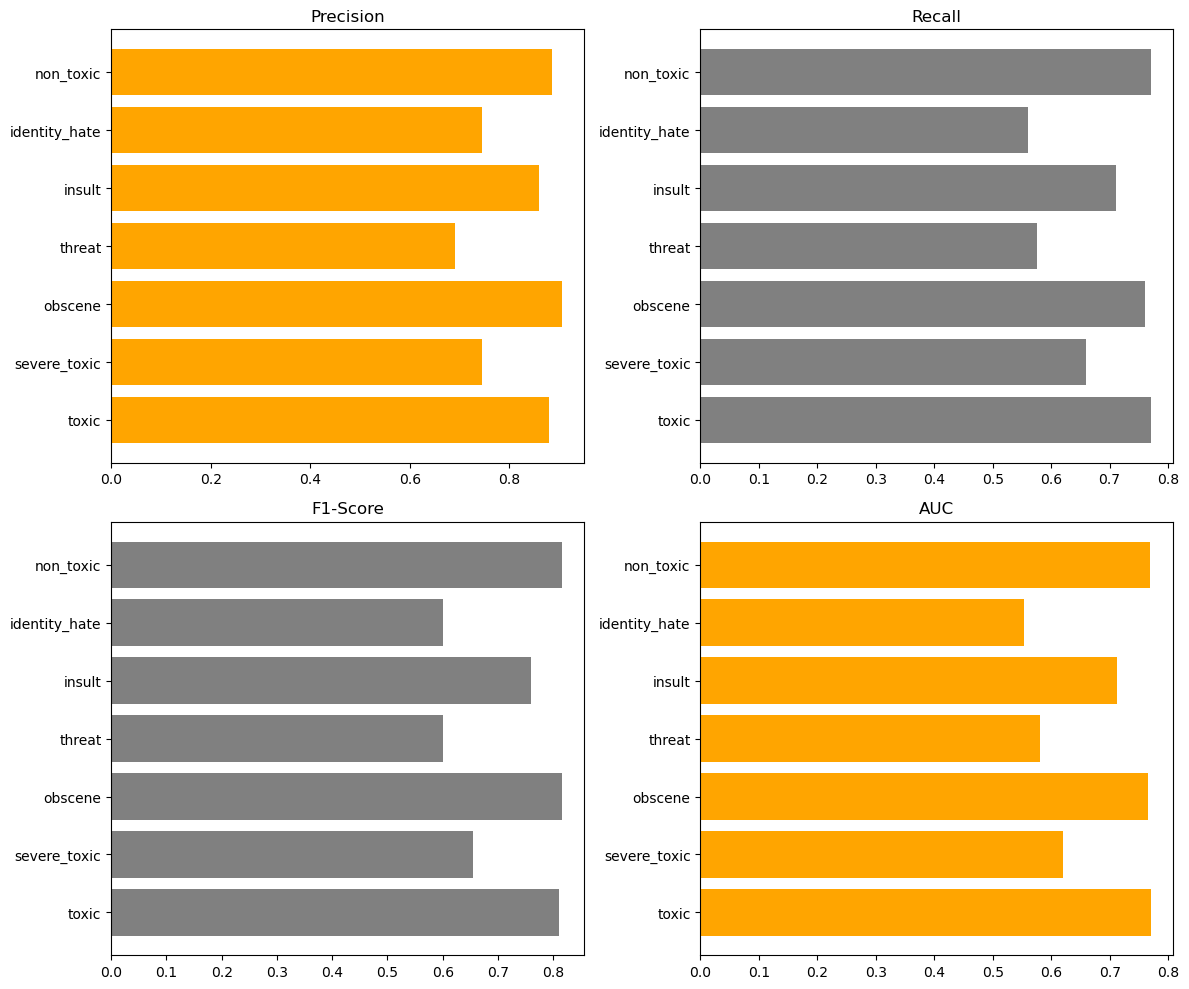

In [23]:
import matplotlib.pyplot as plt

# Define the labels and corresponding metrics
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
precision = [0.88, 0.745, 0.905, 0.69, 0.86, 0.745, 0.885]  
recall = [0.77,0.66,0.76,0.575,0.71,0.56,0.77]     
f1_score = [0.81,0.655,0.815,0.60,0.76,0.6,0.815]   
auc = [0.7695, 0.6202, 0.7652, 0.5807, 0.7114, 0.5538, 0.7678]  

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].barh(labels, precision, color='orange')
axs[0, 0].set_title('Precision')

axs[0, 1].barh(labels, recall, color='grey')
axs[0, 1].set_title('Recall')

axs[1, 0].barh(labels, f1_score, color='grey')
axs[1, 0].set_title('F1-Score')

axs[1, 1].barh(labels, auc, color='orange')
axs[1, 1].set_title('AUC')

plt.tight_layout()

# Show plot
plt.show()


# NAIVE BAYES:


In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score

In [25]:
train_balanced['non_toxic'] = 1 - train_balanced[target_columns].max(axis=1)

In [26]:
nb_classifier = GaussianNB()
average_auc_toxic = 0
average_auc_non_toxic = 0

In [27]:
from sklearn.model_selection import train_test_split

# Assuming you've already split x_train and train_balanced
x_train, x_val, y_train, y_val = train_test_split(f_matrix_train, train_balanced, test_size=0.2, random_state=42)

for label in target_columns + ['non_toxic']:
    # Train model
    nb_classifier.fit(x_train, y_train[label])
    
    # Make predictions
    predictions = nb_classifier.predict(x_val)
    
    # Output classification report
    print(f'Label = {label}')
    print(classification_report(y_val[label], predictions))
    
    # Calculate and accumulate AUC
    roc_auc = roc_auc_score(y_val[label], predictions)
    print(f'AUC for {label}: {roc_auc}')
    if label != 'non_toxic':
        average_auc_toxic += roc_auc
    else:
        average_auc_non_toxic = roc_auc

# Calculate average AUC
average_auc_toxic /= len(target_columns)
average_auc_non_toxic /= 1  # Since there's only one non-toxic class

print(f'Average AUC for Toxic: {average_auc_toxic}')
print(f'Average AUC for Non-Toxic: {average_auc_non_toxic}')


Label = toxic
              precision    recall  f1-score   support

           0       0.96      0.86      0.90     28859
           1       0.32      0.64      0.43      3056

    accuracy                           0.84     31915
   macro avg       0.64      0.75      0.67     31915
weighted avg       0.90      0.84      0.86     31915

AUC for toxic: 0.7465523211429319
Label = severe_toxic
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     31594
           1       0.07      0.76      0.14       321

    accuracy                           0.90     31915
   macro avg       0.54      0.83      0.54     31915
weighted avg       0.99      0.90      0.94     31915

AUC for severe_toxic: 0.8331455438224498
Label = obscene
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     30200
           1       0.23      0.66      0.34      1715

    accuracy                           0.86     31915
  

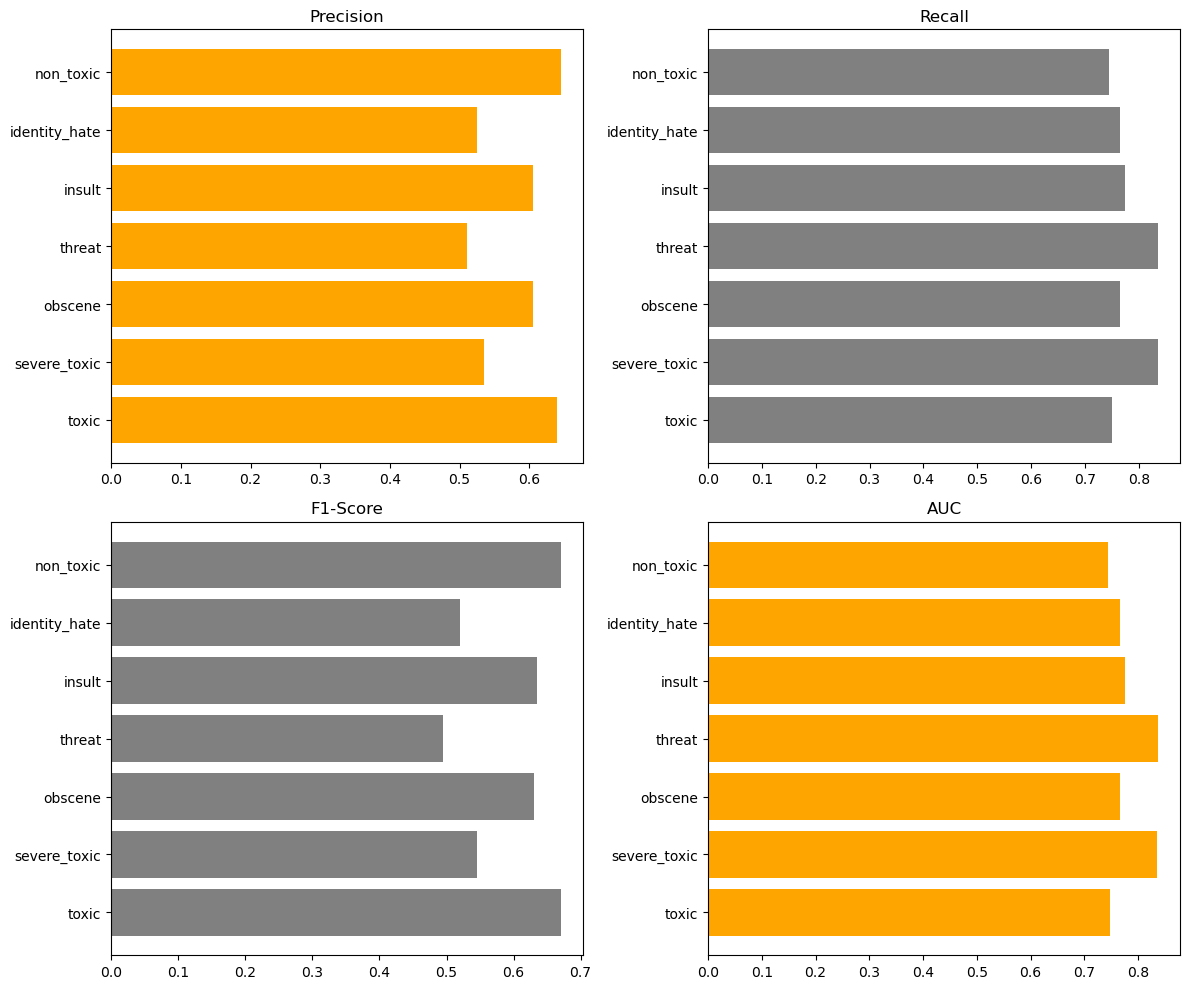

In [28]:
import matplotlib.pyplot as plt

# Define the labels and corresponding metrics
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
precision = [0.64,0.535,0.605,0.51,0.605,0.525,0.645]  
recall = [0.75,0.835,0.765,0.835,0.775,0.765,0.745]     
f1_score = [0.67,0.545,0.63,0.495,0.635,0.52,0.67]   
auc = [0.7473, 0.8345, 0.7668, 0.8363, 0.7754, 0.7666, 0.745]  

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].barh(labels, precision, color='orange')
axs[0, 0].set_title('Precision')

axs[0, 1].barh(labels, recall, color='grey')
axs[0, 1].set_title('Recall')

axs[1, 0].barh(labels, f1_score, color='grey')
axs[1, 0].set_title('F1-Score')

axs[1, 1].barh(labels, auc, color='orange')
axs[1, 1].set_title('AUC')

plt.tight_layout()

# Show plot
plt.show()


# AdaBoost Classifier

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

# Sample labels for the example

target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['non_toxic'] = 1 - train[target_columns].max(axis=1)  # Define non-toxic as the absence of all toxic behaviors

# Split the dataset
x_train, x_val, y_train, y_val = train_test_split(f_matrix_train, train, test_size=0.2, random_state=42)

# Initialize AdaBoost with a simpler and faster base estimator, fewer estimators, and specify the algorithm explicitly
base_estimator = DecisionTreeClassifier(max_depth=1)  # Using a decision stump
ada_classifier = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    random_state=42,
    algorithm='SAMME'  # Explicitly using SAMME algorithm to avoid the deprecation warning
)

# Dictionary to store AUC scores for averaging later
auc_scores = {}

# Fit AdaBoost and evaluate for each label including 'non_toxic'
for label in target_columns + ['non_toxic']:
    ada_classifier.fit(x_train, y_train[label])
    predictions = ada_classifier.predict(x_val)
    
    # Display classification report
    print(f'Label = {label}')
    print(classification_report(y_val[label], predictions))
    
    # Calculate and print AUC
    roc_auc = roc_auc_score(y_val[label], predictions)
    print(f'AUC for {label}: {roc_auc}')
    auc_scores[label] = roc_auc

# Calculate average AUC for toxic and non-toxic classes
average_auc_toxic = np.mean([auc_scores[label] for label in target_columns])
average_auc_non_toxic = auc_scores['non_toxic']

print(f'Average AUC for Toxic: {average_auc_toxic}')
print(f'Average AUC for Non-Toxic: {average_auc_non_toxic}')


Label = toxic
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     28859
           1       0.73      0.56      0.63      3056

    accuracy                           0.94     31915
   macro avg       0.84      0.77      0.80     31915
weighted avg       0.93      0.94      0.93     31915

AUC for toxic: 0.7665621282589169
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31594
           1       0.41      0.28      0.33       321

    accuracy                           0.99     31915
   macro avg       0.70      0.64      0.66     31915
weighted avg       0.99      0.99      0.99     31915

AUC for severe_toxic: 0.6365877566169056
Label = obscene
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30200
           1       0.74      0.50      0.59      1715

    accuracy                           0.96     31915
  